# Distribution of absolute baseline lengths

Last run with Jupyter Notebook 5.7.4 running Python 3.7.2

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

## Get information on the available layouts

In [2]:
layout_dir = os.path.join('..', 'data', 'layouts')

In [3]:
ls $layout_dir

SKA1_Low_rev_02.txt       SKA1_Mid_rev_03.txt       readme.txt
SKA1_Low_rev_03.txt       SKA1_Mid_rev_04.txt
SKA1_Mid_rev_02.txt       SKA1_Mid_rev_05_prop.txt


In [4]:
cat $layout_dir/readme.txt

SKA Telescope Layouts

SKA1-Low
--------

SKA1-Low coordinates are given in SKA-TEL-SKO-0000422. The revisions
of the document are as follows:

Rev 01 - corresponding to ECP-150037. This predates the CDR design
         baseline, so this layout is not included here.

Rev 02 - corresponding to ECP-160015.

Rev 03 - corresponding to ECP-170049.


SKA1-Mid
--------

SKA1-Mid coordinates are given in SKA‐TEL‐INSA‐0000537. The revisions
of the document are as follows:

Rev 01 - no ECP. This predates the CDR design baseline, so this layout
         is not included here.

Rev 02 - no ECP.

Rev 03 - no ECP.

Rev 04 - corresponding to ECP-180002. Note the Excel spreadsheet
         accompanying this revision has one extra decimal place in the
         longitude values compared to the PDF version. The values from
         the PDF have been used here.

Rev 05 (prop) - potential revision, corresponding to the changes proposed in
                ECP-180018.


## Define functions for reading the layouts

They return two values:
- position of array centre;
- array of element positions.

The SKA1-Low layouts define the array centre explictly as the first entry in the file. The SKA1-Mid layouts use the first array element (MeerKAT antenna M000) as the position of the array centre.

In [5]:
dtype_pos = np.dtype([('name', 'U10'), ('lon', 'f8'), ('lat', 'f8')])

In [6]:
def read_low_layout(filename):
    pos = np.loadtxt(filename, usecols=(1, 2, 3), dtype=dtype_pos)
    cpos = pos[0]
    epos = pos[1:]
    return cpos, epos    

In [7]:
def read_mid_layout(filename):
    pos = np.loadtxt(filename, usecols=(0, 1, 2), dtype=dtype_pos)
    cpos = pos[0]
    cpos['name'] = 'Centre'
    epos = pos
    return cpos, epos

## Define functions for computing the baseline length distribution.

This version doesn't do projection of the baselines.

In [8]:
def baseline_distribution(cpos, epos, bins):

    Rearth = 6371010.0/1000.0
    degtorad = np.pi/180.0

    array_x_centre = Rearth * np.cos(cpos['lat']*degtorad) * np.cos(cpos['lon']*degtorad)
    array_y_centre = Rearth * np.cos(cpos['lat']*degtorad) * np.sin(cpos['lon']*degtorad)
    array_z_centre = Rearth * np.sin(cpos['lat']*degtorad)

    Array_dx = []
    Array_dy = []
    Array_dz = []
    Array_r = []
    Baseline_lengths_uv = []

    Number_positions = len(epos)
    print('Number of positions:', Number_positions)

    for i in range(Number_positions):
        Array_dx.append(Rearth*np.cos(epos['lat'][i]*degtorad)*np.cos(epos['lon'][i]*degtorad)-array_x_centre)
        Array_dy.append(Rearth*np.cos(epos['lat'][i]*degtorad)*np.sin(epos['lon'][i]*degtorad)-array_y_centre)
        Array_dz.append(Rearth*np.sin(epos['lat'][i]*degtorad)-array_z_centre)
        Array_r.append(np.sqrt(Array_dx[i]**2+Array_dy[i]**2+Array_dz[i]**2))

    Baseline_lengths = []
    for i in range(Number_positions):
        for j in range(Number_positions):
            if j > i:
                blength=(np.sqrt((Array_dx[j]-Array_dx[i])**2 + (Array_dy[j]-Array_dy[i])**2 + (Array_dz[j]-Array_dz[i])**2))
                Baseline_lengths.append(blength)
    
    print('Number of baselines:', len(Baseline_lengths))
    print('Number of bins used:', len(bins)-1)

    n, bins, patches = plt.hist(Baseline_lengths, bins, density=False, histtype='stepfilled')
    plt.ylabel('Number of baselines')
    plt.xlabel('Baseline length, km')
    plt.yscale('log')
    plt.show()

    percents = 100 * n / sum(n)

    print('Bin upper edges:', 1000.0 * bins[1:])
    print('Percentage baselines per bin:', percents)

This version does do projection of the baselines (in a somewhat haphazard way).

In [9]:
def baseline_distribution_with_projection(cpos, epos, bins):

    Rearth = 6371010.0/1000.0
    degtorad = np.pi/180.0

    array_x_centre = Rearth * np.cos(cpos['lat']*degtorad) * np.cos(cpos['lon']*degtorad)
    array_y_centre = Rearth * np.cos(cpos['lat']*degtorad) * np.sin(cpos['lon']*degtorad)
    array_z_centre = Rearth * np.sin(cpos['lat']*degtorad)

    Array_dx = []
    Array_dy = []
    Array_dz = []
    Array_r = []
    Baseline_lengths_uv = []

    Number_positions = len(epos)
    
    for i in range(Number_positions):
        Array_dx.append(Rearth*np.cos(epos['lat'][i]*degtorad)*np.cos(epos['lon'][i]*degtorad)-array_x_centre)
        Array_dy.append(Rearth*np.cos(epos['lat'][i]*degtorad)*np.sin(epos['lon'][i]*degtorad)-array_y_centre)
        Array_dz.append(Rearth*np.sin(epos['lat'][i]*degtorad)-array_z_centre)
        Array_r.append(np.sqrt(Array_dx[i]**2+Array_dy[i]**2+Array_dz[i]**2))

    phi_degrees = [-40, -30, -10, 0, 10, 20, 30, 40]
    elevation_degrees = [50, 60, 70]

    for k in range(len(phi_degrees)):
        phi = phi_degrees[k] / 57.3 
        #print('phi is', phi * 57.3)
        for l in range(len(elevation_degrees)):
            elevation=elevation_degrees[l] / 57.3
            #print('elevation is', elevation * 57.3)
            for i in range(Number_positions):
                for j in range(Number_positions):
                    if j > i:
                        #rotate baselines to phi position (phi=0 means looking eastwards, phi=pi/2 means looking north)
                        #then reduce baseline lengths in direction of view by elevation factor
                        a = (Array_dx[j]-Array_dx[i])*np.cos(phi) - (Array_dy[j]-Array_dy[i])*np.sin(phi)
                        b = (Array_dx[j]-Array_dx[i])*np.sin(phi) + (Array_dy[j]-Array_dy[i])*np.cos(phi)
                        blength_uv = np.sqrt((a*np.sin(elevation))**2 + (b)**2)
                        Baseline_lengths_uv.append(blength_uv)
                                        
    print('Total number of baselines in all projections:', len(Baseline_lengths_uv))
    print('Number of bins used:', len(bins)-1)

    n, bins, patches = plt.hist(Baseline_lengths_uv, bins, density=False, histtype='stepfilled')
    plt.ylabel('Number of baselines')
    plt.xlabel('Baseline length, km')
    plt.yscale('log')
    plt.show()

    percents = 100 * n / sum(n)

    print('Bin upper edges:', 1000.0 * bins[1:])
    print('Percentage baselines per bin:', percents)

## Baseline distribution for SKA1-Low

Number of positions: 512
Number of baselines: 130816
Number of bins used: 5


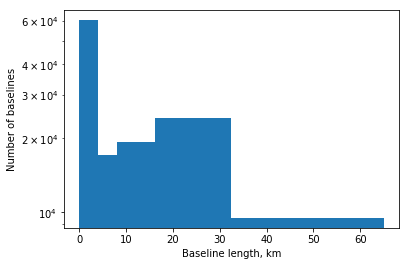

Bin upper edges: [ 4062.5  8125.  16250.  32500.  65000. ]
Percentage baselines per bin: [46.30065759 13.06774736 14.78360606 18.58770454  7.26028445]


In [10]:
layout = 'SKA1_Low_rev_03.txt'
layout_file = os.path.join(layout_dir, layout)
cpos, epos = read_low_layout(layout_file)
baseline_bins = np.array((0.0, 65.0/16.0, 65.0/8.0, 65.0/4.0, 65.0/2.0, 65.0))
baseline_distribution(cpos, epos, baseline_bins)

## Baseline distribution for SKA1-Mid

Number of positions: 197
Number of baselines: 19306
Number of bins used: 12


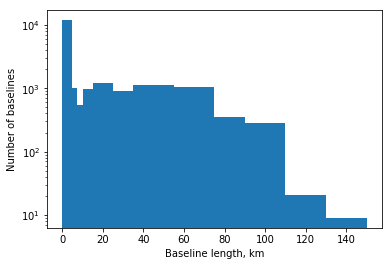

Bin upper edges: [  5000.   7500.  10000.  15000.  25000.  35000.  55000.  75000.  90000.
 110000. 130000. 150000.]
Percentage baselines per bin: [6.13646961e+01 5.16553546e+00 2.87031760e+00 4.98937879e+00
 6.32609709e+00 4.63706544e+00 5.73545412e+00 5.50230558e+00
 1.80301539e+00 1.45070204e+00 1.08802653e-01 4.66297083e-02]


In [11]:
layout = 'SKA1_Mid_rev_04.txt'
layout_file = os.path.join(layout_dir, layout)
cpos, epos = read_mid_layout(layout_file)
baseline_bins = np.array((0.0, 5.0, 7.5, 10.0, 15.0, 25.0, 35.0, 55.0, 75.0, 90.0, 110.0, 130.0, 150.0))
baseline_distribution(cpos, epos, baseline_bins)